[View in Colaboratory](https://colab.research.google.com/github/liufei11111/deep_dream_demo/blob/master/py2_a_whirlwind_tour_of_ai_art.ipynb)

# A (Brief) Tour of AI Art

#### by Andrew Look

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/title/IMG_7772_guided.gif" width=400 />


> *“Whatever you now find weird, ugly, uncomfortable, and nasty about a new medium will surely become its signature.*

> *CD distortion, the jitteriness of digital video, the crap sound of 8-bit, all of these will be cherished and emulated as soon as they can be avoided. It’s the sound of failure.*

> *So much modern art is the sound of things going out of control. Out of a medium, pushing to its limits and breaking apart.”*

> -- [Brian Eno](https://www.goodreads.com/quotes/649039-whatever-you-now-find-weird-ugly-uncomfortable-and-nasty-about)

<!-- https://blog.ycombinator.com/making-music-and-art-through-machine-learning-doug-eck-of-magenta/ -->

<img src="https://courses.cs.washington.edu/courses/cse576/13sp/images/eigenfaces.png" width=400 />

<!-- ![eigenfaces](https://courses.cs.washington.edu/courses/cse576/13sp/images/eigenfaces.png) -->
[image credit](https://courses.cs.washington.edu/courses/cse576/13sp/projects/project3/)


# Before we begin

## You Are here because:

- You are aware of AI but might not have heard about artistic uses
- You're curious to learn how AI can augment the creative process


## By the end of this tour

**My goal is to help you understand:**
- How using AI art tools can *augment* your creativity

- How some existing artists are incorporating AI tools and concepts into their work

- Just enough tools, concepts, and aesthetic options to begin making your own AI art

- Aesthetic controls at a deeper level, for one particular technique *(deepdreams)*

- Where to learn more if you want to get involved!

## About Me

I'm Andrew Look, ML engineer on the Knowledge team at Pinterest.

I work on building classifier algorithms to look at each pin and determine its Taste Graph Interests.

I started painting as a stress-relief hobby from startup life pre-Pinterest.


In [0]:
# asset ideas:
# - hacker companion painting
# - me asleep with book
# - pinterest yearbook

## Disclaimer: not a real expert on computer vision, neuroscience or art

But I *have* spent a couple years learning about the space, so I'll do my best to explain things as I understand them so far.

## Disclaimer: For those more familiar with AI
- I plan on making some broad generalizations in the interests of brevity.
- If you're interested in the technical details, I'll have resources for you afterwards!

## Following along

If you don't have a laptop, this presentation is designed to still be interesting and useful.


**Request:** Audience volunteer to slack me an image I can use for demos: `@look`

If you have a laptop, you may follow along using this interactive notebook hosted on Google Colab: **[Start Here](https://colab.research.google.com/github/andrewlook/tour-of-ai-art/blob/master/notebooks/a_whirlwind_tour_of_ai_art.ipynb#scrollTo=-88s3MpezIVD)**

## https://bit.ly/2K1RNaE

# Start here

All you need to do to follow along are a few steps:
1. Save a copy of the Notebook in your own Google Drive account
2. Change runtime to GPU
3. Upload your photo(s) and display them
4. Kick off the longer setup scripts and wait a few mins
5. Test deepdream just to make sure everything works

## Step 1 - Save a copy

If you want to save your notebook to you own Google Drive account.

In the top menu, choose **File -> Save a copy in drive** from the top menu when you're ready to save.

## Step 2 - Change Runtime to "GPU"

This makes notebook run much, much faster.

In the top menu, Click **Runtime** and then select **Change Runtime Type**.

Then, click the **Hardware Accelerator** dropdown, select **GPU** and then click **Save**

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/gpu_py2_colab.png" width=400 />


When you're done, running the following code cell should confirm that a GPU is available:

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import sys
print(sys.version)
assert sys.version.startswith('2')

Found GPU at: /device:GPU:0
2.7.14 (default, Sep 23 2017, 22:06:14) 
[GCC 7.2.0]


## Step 3 - Kick off the longer setup scripts and wait a few mins

There's a bunch of big blobs of code below - if you skip down to a cell below them and run the following, it will execute all cells before that one:
**`<Cmd>-<fn>-F8`**
(Note: you may not need to press `fn` key).

[Click here](#scrollTo=BqovZ9fu5Vrf) to jump ahead to the right cell.


In [0]:
# basic image mgmt functions


!pip install scikit-image lucid

from __future__ import print_function
import numpy as np
import PIL

from IPython import display as ipyd
from lucid.misc.io import reading, showing
from skimage import io
# http://scikit-image.org/docs/dev/api/skimage.transform.html
from skimage import transform
from IPython import display as ipyd

# from https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
def crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)    
    return img[starty:starty+cropy, startx:startx+cropx, :]
 
def square_shrink(img, dim):
  smaller_dim = min(img.shape[:2])
  cropped = crop_center(img, smaller_dim, smaller_dim)
  small_cropped = transform.resize(cropped, (dim, dim, img.shape[2]), mode='constant')
  return small_cropped

def load_img(fname, dim=None):
  img = io.imread(fname)
  if not dim:
    return transform.resize(img, (img.shape[0], img.shape[1], img.shape[2]), mode='constant')
  small_img = square_shrink(img, dim=dim)
  return small_img

def upload_images():
  from google.colab import files
  uploaded = files.upload()
  img_fnames = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    img_fnames.append(fn)
  return img_fnames

In [0]:
### Tensorflow deepdream model (inception5h)

# first, download a pretrained model to use
import os
if not os.path.exists('inception5h.zip'):
  !wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip && unzip inception5h.zip

In [0]:
### Tensorflow Deepdream Code
# - Source: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream
# - Original notebook: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
#
# Other references:
# - https://github.com/mtyka/deepdream_highres
#
# Source is inlcuded under Apache V2 License:
# - https://github.com/tensorflow/tensorflow/blob/master/LICENSE

# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                s = "<stripped %d bytes>"%size
                tensor.tensor_content = str(s).encode('utf-8')
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

In [0]:
## visualizing neuron activations


# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))
    
    
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
render_naive(T(layer)[:,:,:,channel])

In [0]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

# Helper function that uses TF to resize an image
def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)


def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)
  
  
def render_multiscale(t_obj, img0=img_noise, iter_n=10, step=1.0, octave_n=3, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            # normalizing the gradient, so the same step size should work 
            g /= g.std()+1e-8         # for different layers and networks
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visstd(img))
        
        
render_multiscale(T(layer)[:,:,:,channel])

In [0]:
k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)

def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

  
def render_lapnorm(t_obj, img0=img_noise, visfunc=visstd,
                   iter_n=10, step=1.0, octave_n=3, octave_scale=1.4, lap_n=4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    # build the laplacian normalization graph
    lap_norm_func = tffunc(np.float32)(partial(lap_normalize, scale_n=lap_n))

    img = img0.copy()
    for octave in range(octave_n):
        if octave>0:
            hw = np.float32(img.shape[:2])*octave_scale
            img = resize(img, np.int32(hw))
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            g = lap_norm_func(g)
            img += g*step
            print('.', end = ' ')
        clear_output()
        showarray(visfunc(img))

# Showing the lap_normalize graph with TensorBoard
lap_graph = tf.Graph()
with lap_graph.as_default():
    lap_in = tf.placeholder(np.float32, name='lap_in')
    lap_out = lap_normalize(lap_in)
show_graph(lap_graph)


In [0]:
render_lapnorm(T(layer)[:,:,:,channel])

In [0]:
render_lapnorm(T(layer)[:,:,:,65])

In [0]:
def render_deepdream(t_obj, img0=img_noise,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        clear_output()
        showarray(img/255.0)        

In [0]:
# Semantic Dictionary setup from:
# TODO(look): rem`ove my workaround once the py3 bud gets patched

# - https://github.com/tensorflow/lucid/blob/master/notebooks/building-blocks/SemanticDictionary.ipynb
# Used under Apache V2 License:
# ---------------------------------------------------------------------
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# TODO(look): remove my "workaround" once the py3 bud gets patched
# !pip uninstall lucid
# !rm -rf /opt/lucid /content/src/lucid && git clone https://github.com/andrewlook/lucid.git /opt/lucid && cd /opt/lucid/ && git checkout py3
# ! cd /opt/lucid && python setup.py --quiet install
# !ls /opt/lucid/lucid/scratch/web/svelte.py
# !cp /opt/lucid/lucid/scratch/web/svelte.py .
# import svelte as lucid_svelte
!pip install --quiet lucid
import lucid.scratch.web.svelte as lucid_svelte

!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url


In [0]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

In [0]:
layer_spritemap_sizes = {
    'mixed3a' : 16,
    'mixed3b' : 21,
    'mixed4a' : 22,
    'mixed4b' : 22,
    'mixed4c' : 22,
    'mixed4d' : 22,
    'mixed4e' : 28,
    'mixed5a' : 28,
  }

def googlenet_spritemap(layer):
  assert layer in layer_spritemap_sizes
  size = layer_spritemap_sizes[layer]
  url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_%s_channel_alpha.jpeg" % layer
  return size, url

googlenet = models.InceptionV1()
googlenet.load_graphdef()


def googlenet_semantic_dict_from_url(layer, img_url):
    img = load(img_url)
    googlenet_semantic_dict(layer, img)
    
# ## **User facing constructor**
# Now we'll create a convenient API for creating semantic dictionary
# visualizations. It will compute the network activations for an image,
# grab an appropriate spritemap, and render the interface.
def googlenet_semantic_dict(layer, img):    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [224, 224, 3])
        T = render.import_model(googlenet, t_input, t_input)
        acts = T(layer).eval({t_input: img})[0]
    
    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = googlenet_spritemap(layer)
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 110,
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img),
        "activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [max_y, max_x]
    })
   
   


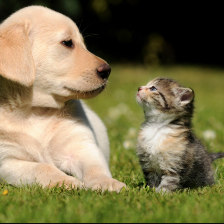

In [0]:
googlenet_semantic_dict_from_url("mixed4d", "https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

### Jump down here and run all setup cells at once

run the following, it will execute all cells before that one:
**`<Cmd>-<fn>-F8`**
(Note: you may not need to press `fn` key).

In [0]:
# First run <Cmd>-<fn>-F8, to run all cells before this one.

# While you're waiting, you can hit <Shift>-Enter in this cell,
# and it will generate some output to verify that everything got set
# up correctly.

### Test deepdream just to make sure everything works
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize
render_naive(T(layer)[:,:,:,channel])
render_multiscale(T(layer)[:,:,:,channel])
render_lapnorm(T(layer)[:,:,:,channel])


## Step 4 - Upload your photo(s) and display them




In [0]:
# run this to display file upload form, and click "Choose Files"
image_filenames = upload_images()


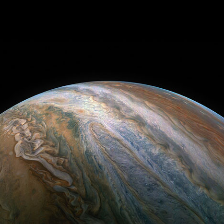
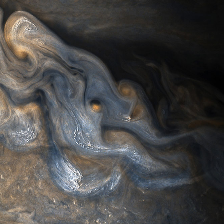


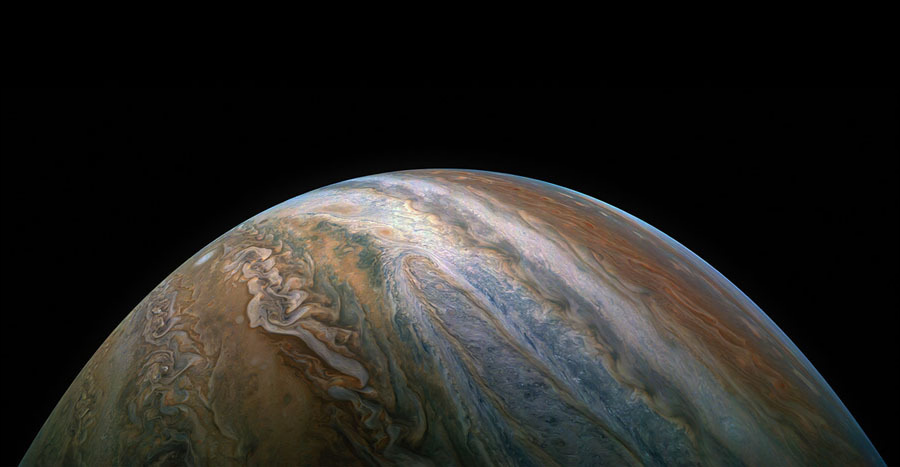
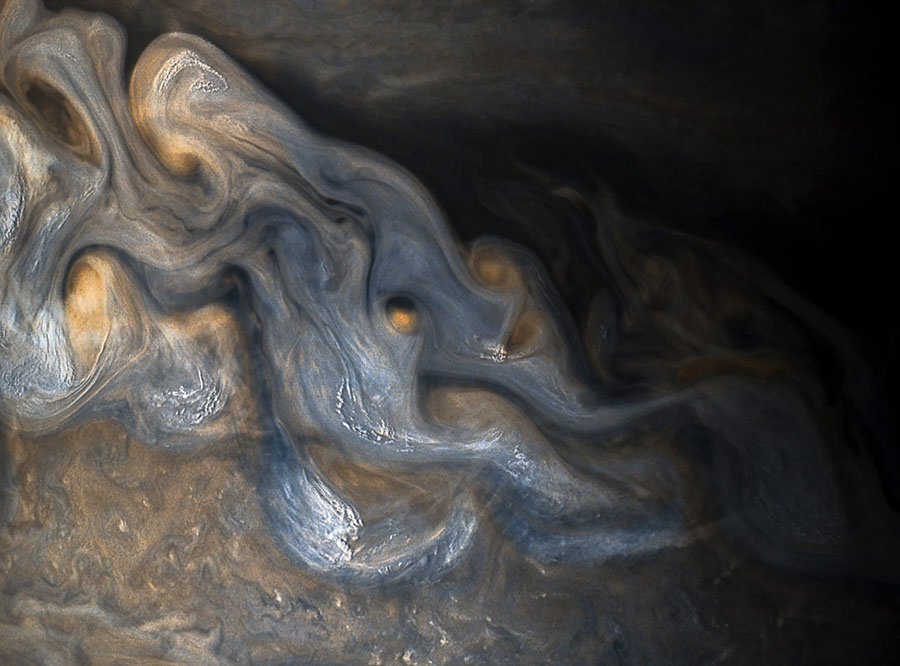

In [0]:
# since images can be pretty large (and slow down the notebook to render them),
# it's handy to have some lower-res versions to quickly experiment with.
small_imgs = [load_img(f, dim=224) for f in image_filenames]
# use a helper from lucid to display the images neatly:
showing.images(small_imgs, labels=image_filenames)

# also load the full images, in case you want a high-res deepdream
large_imgs = [load_img(f) for f in image_filenames]
showing.images(large_imgs, labels=image_filenames, w=400)

# for the rest of the notebook to go smoothly, we'll keep a pointer to the first
# images that we loaded:
small_img_0 = small_imgs[0]
large_img_0 = large_imgs[0]

## Colab Hints

If you want to learn more about how to navigate Colab:
- [Tensorflow with GPU](https://colab.research.google.com/notebooks/gpu.ipynb)
- [Loading External Data](https://colab.research.google.com/notebooks/io.ipynb)

To get a brief overview of Colab's features:
- [Hello, Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb#scrollTo=-Rh3-Vt9Nev9)
- [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

# What is AI art?

Definition #1: **Making creative use of outputs from an AI *Tool* **



## Example: [pix2pix](https://affinelayer.com/pixsrv/)

Even without much context on how it works, Pix2Pix is fun to play with and yields wierd results.

We'll look at some more in-depth approaches later (time permitting), but for now this is just fun.

![bread_cat](https://media.giphy.com/media/fik7beSODmO75YI6Qd/giphy.gif)

Based on: [*"Image-to-Image Translation with Conditional Adversarial Networks"*, Isola et al, 2017](https://arxiv.org/abs/1611.07004)

<!-- ![pix2pix_pyramid_cat](https://media.giphy.com/media/wHYLEo4Z7kPJwlbO9U/giphy.gif) -->

Definition #2: **Leveraging how AI represents information to deliberately craft an *Effect* **


## Example: "Face Space"

For example, recent generative algorithms have rapidly improved their ability both to learn **latent spaces**, and to **generate** images from any point in these latent spaces.

In fact, those spooky faces earlier came from a visualization of Eigenfaces, which sought to "learn" how to represent faces in a "latent space".

![facespace](https://onionesquereality.files.wordpress.com/2009/02/face_space.jpg)

Source: [*Face Recognition using Eigenfaces,* Turk et al, 1991](http://www.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

## Example: [Toposketch](https://vusd.github.io/toposketch/)

Researchers have built tools to allow visual navigation of latent spaces in order to gain fine-grained control over the generated artifacts.

![toposketch_man_loop](https://media.giphy.com/media/5BYqBxH66X3UobP3SH/giphy.gif)



Definition #3: **Exploring the *Concepts* within AI and what they mean for us**

## Example: Treachery of Imagenet

![img](https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/tom_white_adversarial_posters.jpg)

[source](https://medium.com/artists-and-machine-intelligence/perception-engines-8a46bc598d57)

## Example: Simulating How Humans Draw

![](https://media.giphy.com/media/OjY1YSX6jFROm02W0J/giphy.gif)

[source](https://deepmind.com/blog/learning-to-generate-images/)


## Framework to discuss AI Art

- Definition #1: **Making creative use of outputs from an AI *Tool* **
- Definition #2: **Leveraging how AI represents information to deliberately craft an *Effect* **
- Definition #3: **Exploring the *Concepts* within AI and what they mean for us**

Moving forwards, we'll use **Tool**, **Effect**, and **Concept** to interpret different examples of art.

# But first...

## What does AI actually mean?

AI is a term used in so many contexts, that it can be confusing for an audience.

Most mentions of AI can be bucketed into one of two broad categories:
- **General AI**: The futuristic aspiration of computers that experience consciousness
- **Specialized AI**: Systems using statistics to learn patterns from data in order to make predictions.

## What kind of AI are we focusing on today?

The **Specialized** kind (also known as **Machine Learning**).

We'll be focused on artistic applications of techniques that have sprung out of real-world research.

Many artistic tools come from people striving to understand algorithms affect our lives.
<!-- related: Explainability / Interpretability, Algorithmic Accountability -->

Sorry to disappoint, but this tutorial won't cover robots that paint:

![not this](https://media.giphy.com/media/8P7fmIpUYBwHgjo322/giphy.gif)

Source: Deepmind [blog](https://deepmind.com/blog/learning-to-generate-images/) [pdf](https://deepmind.com/documents/183/SPIRAL.pdf) [youtube](https://www.youtube.com/watch?v=iSyvwAwa7vk)

## OK, so what is ML?

Machine Learning (usually) refers to a type of algorithm that:
- **learns** patterns and relationships from **training data**
- is built to perform a clearly-defined **task**.



### A Simple Example

Imagine we want to predict housing prices.

We'd probably start with a spreadsheet of prices we know to be true, alongside features for each house that we expect to be related to the price.

![housepricestable](https://cdn-images-1.medium.com/max/1280/1*TE_oNKRRek5io8v_-uZ9PQ.png)

Source: [medium.com/@kabab](https://medium.com/@kabab/linear-regression-with-python-d4e10887ca43)

If we plot price vs. size on this toy dataset, we can start to see a slope

![housepricesscatter](https://cdn-images-1.medium.com/max/1280/1*HUJzcLczeBFRdPPZ5HMcbw.png)

### Predicting price using the house size

If we were to draw a line through these points, the "slope" would be what you multiply the `size` by in order to get the `price` (plus a "bias" term, if the slope doesn't meet the Y-axis right at zero).

The **objective** of an ML algorithm is to find a line to draw through these points that **minimizes the error** in its predictions.

You can visualize the **error** as the distance from each real data point's `Y` coordinate to the **prediction**: the line's value at the corresponding `X` coordinate.

![errorbars](https://cdn-images-1.medium.com/max/1280/1*iBDH0gBBJNs-oLqUT17yng.png)

### What "Learning" Means

The way ML algorithms "learn" is defined by their **objective**.

In this case, they can start with a proposed line to draw, calculate the error, and make a next guess about what the best line could be.

This process gets repeated, and if everything goes according to plan, the errors decrease.

![iterativelearning](https://cdn-images-1.medium.com/max/1280/1*xc5CSmK9d8oeKYxKxenEGg.gif)

## What is art?

Out of respect to artists everywhere, I'm not going to try to define it.




---

What's relevant here is that art can be defined by whoever is creating it.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f6/Duchamp_Fountaine.jpg" width=400 />
*"Fountain," Marcel Duchamp, 1917* Source: [wikipedia](https://en.wikipedia.org/wiki/Marcel_Duchamp)

# Back to AI Art


Definition #1: **Making creative use of outputs from an AI *Tool* **

Definition #2: **Leveraging how AI represents information to deliberately craft an *Effect* **

Definition #3: **Exploring the *Concepts* within AI and what they means for us**




These definitions actually mirror the progression of my own art practice.

I'll step through them in an attempt to share how my understanding of the space has evolved since I first started.

# Definition #1: Making creative use of outputs from an AI *Tool*



## My Work: a first use-case for an AI art tool

I started getting serious about learning ML sometime after starting to paint.

Around the same time, I took an art class about "Painting the Personal Narrative," and we needed to make a past / present series of still life paintings.

I started with a "present" painting, which I called "startup dinner" (a joking reference to my somewhat unhealthy eating habits left over from pre-Pinterest life).

![startup_dinner](https://lh3.googleusercontent.com/GznHwRqvdYWzoju9ND-vi4yXrbGGYPwjqW4gajOcz8Po4RTF1rGI3PrJlCIA4OZQRbw7klE4rBagDRs-HXxpvN5ldqfj4J-sAlziBSwOK_ZcNP5RtZyRwXRP2SWuJgBog1jHH-rmwBRC5ec_lxeT1VNqND21iAVCak547gQffAOa6jGWZC2-6CecRw-thU8pt3c9i-9v8c-unAJ645_ni5CSHQYIsIki5cOBaUBAllbh4pcRGHwnN-wsvmpmIb2sSW_NLSe4RSGnNj163N3vcvU9jMq-NMiNBxVnY4DWJGR4C4mG22Xr_Xp6R6N5m_j-Z3vjU2XMevUEJbuaweP4X8rksBEsAJ_5acPeyL2l8mQuzeYUyfuuPpHE7U8OA3DbWuGBf7UKGg8IheaDB4_QmMnPIsT3rZ49aOGRtIZ_TBGvmqSBnU-0GuzukASTjitd4BVi_v7Oa8B2O7hWZhmflv2u2S-UNtkDE6hWeyZXs3UnMjhjbyy1HicNTEDita-JcwtgENJkfXFKaCJnb9wfMBgSdLiNScKzMXe_xz_z50IwDBZvoyHsj7KHHjsiOcmEy0AKnrqDvmk4OyXsEKe_X1854op0AsrwICw3V6CW-Z98UbgRLg75cP6ss1L7tVKRj1-DDMz-GJOjlxullRygCB0q7BADx0e_NA=w494-h658-no)


#### Img Setup


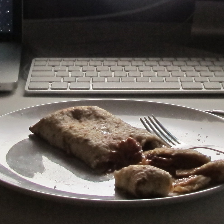
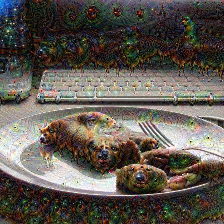

In [0]:
# !cp drive/projects/startup_breakfast/3-breakfast-normal-orig.jpg drive/projects/whirlwind
# !cp drive/projects/startup_breakfast/3-breakfast-normal.jpg drive/projects/whirlwind
# !cp drive/projects/startup_breakfast/4-breakfast-dream.jpg drive/projects/whirlwind

breakfast_normal_full = 'drive/projects/whirlwind/3-breakfast-normal-orig.jpg'
breakfast_normal_cropped = 'drive/projects/whirlwind/3-breakfast-normal.jpg'
breakfast_dream_cropped = 'drive/projects/whirlwind/4-breakfast-dream.jpg'

small_img_0 = load_img(breakfast_normal_cropped, dim=224)
large_img_0 = load_img(breakfast_normal_cropped)

image_filenames = [
    breakfast_normal_cropped,
    breakfast_dream_cropped,
]

# since images can be pretty large (and slow down the notebook to render them),
# it's handy to have some lower-res versions to quickly experiment with.
small_imgs = [load_img(f, dim=224) for f in image_filenames]
# use a helper from lucid to display the images neatly:
showing.images(small_imgs, labels=image_filenames)

# also load the full images, in case you want a high-res deepdream
large_imgs = [load_img(f) for f in image_filenames]
#showing.images(large_imgs, labels=image_filenames, w=400)

# for the rest of the notebook to go smoothly, we'll keep a pointer to the first
# images that we loaded:
small_img_0 = small_imgs[0]
large_img_0 = large_imgs[0]

### Emulating Surrealism?

When we were asked to make a painting of the "past," the prompt was to make it "nightmarish."

I had another photo chosen already, which i jokingly titled "startup breakfast".

The only problem was, I didn't know how to make a dream effect.

<img src="https://raw.githubusercontent.com/andrewlook/tour-of-ai-art/master/notebooks/images/breakfast/breakfast_normal_full.jpeg" width=400 />

### Enter Deepdreams

Thankfully, code for making deepdreams had just been [announced by Google Research](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html).

![deepdream_examples](https://2.bp.blogspot.com/-nxPKPYA8otk/VYIWRcpjZfI/AAAAAAAAAmE/8dSuxLnSNQ4/s640/image-dream-map.png)

### Running my first Deepdream

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/3-breakfast-normal.jpg" width=400 />


<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/4-breakfast-dream.jpg" width=400 />

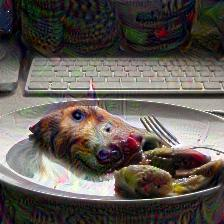

In [0]:
small_new_img = render_deepdream(tf.square(T('mixed4c')), small_img_0*255)

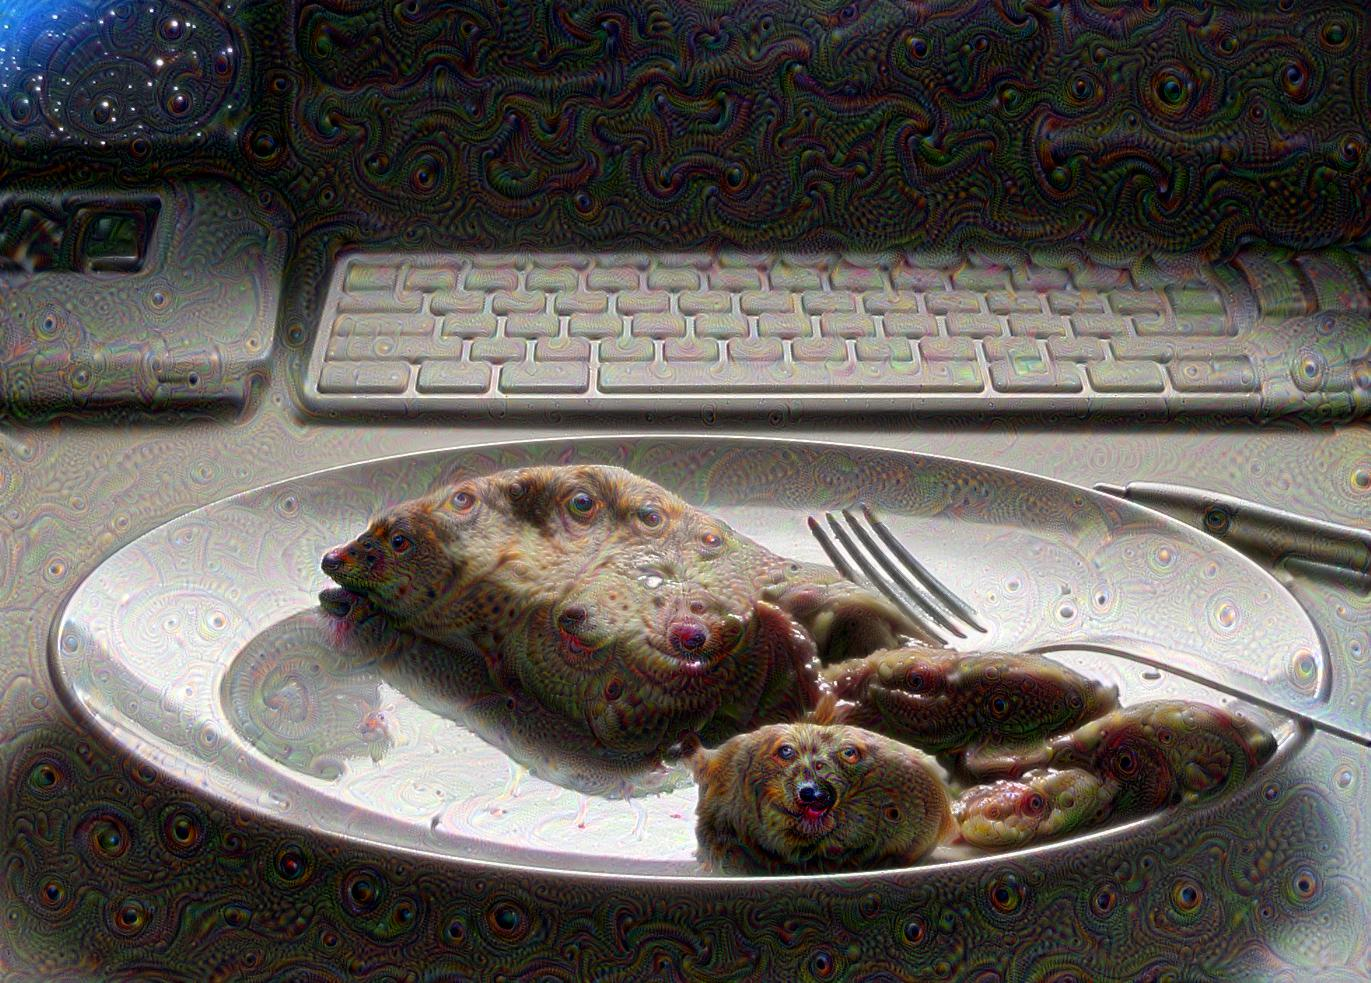

In [0]:

new_img = render_deepdream(tf.square(T('mixed4c')), large_img_0*255)

### Painting it

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/breakfast/paint_2016-11-13-palette-2.jpg" width=400 />


<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/breakfast/paint_2016-11-19.jpg" width=400 />

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/breakfast/IMG_5592.jpg" width=400 />

## What's going on here?

> "That looks like a statement about how animals relate to the food we eat"
>
> -- someone in my art class

> "That was totally not my intention, but let's talk about that!"
>
> -- me

This tool arose from trying to understand what Neural Networks "see".

One way to do this is by understanding which area of the image caused the prediction:

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/attribution.png" width=400 />

source: [distill.pub](https://distill.pub/2017/feature-visualization/)

In [0]:
Instead, the a-ha moment for the deepdream authors was that we could get the neural network to "hallucinate" and how us *"what picture would make this look more like X"*?

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/featureviz.png" width=400 />

> Pareidolia is a type of apophenia, which is a more generalized term for seeing patterns in random data. Some common examples are seeing a likeness of Jesus in the clouds or an image of a man on the surface of the moon. 
>
> -- [source](https://www.livescience.com/25448-pareidolia.html)

<img src="https://img.purch.com/w/640/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzAzNC8zNDMvaTAyL3JvcnNjaGFjaC0wMi5qcGc/MTM1NTI2Njg4MA==" widht=400 />

# Definition #2: **Leveraging how AI represents information to deliberately craft an *Effect* **

In [0]:
> "I paint not the things I see but the feelings they arouse in me"
>
> -- Franz Kline


<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/deepdream_sky1024px.jpeg" width=400 />

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/deepdream_impressionist.jpeg" width=400 />

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/deepdream_surreal.jpeg" width=400 />

<img src="https://cdn-images-1.medium.com/max/1600/1*3rECTefgSkJJ6Sni5sxptA.png" width=600 />

## My Work: exploring high and low layers

<img src="https://github.com/andrewlook/tour-of-ai-art/raw/master/notebooks/images/n2.jpg" width=400/>

## How does it work?

In [0]:
# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)


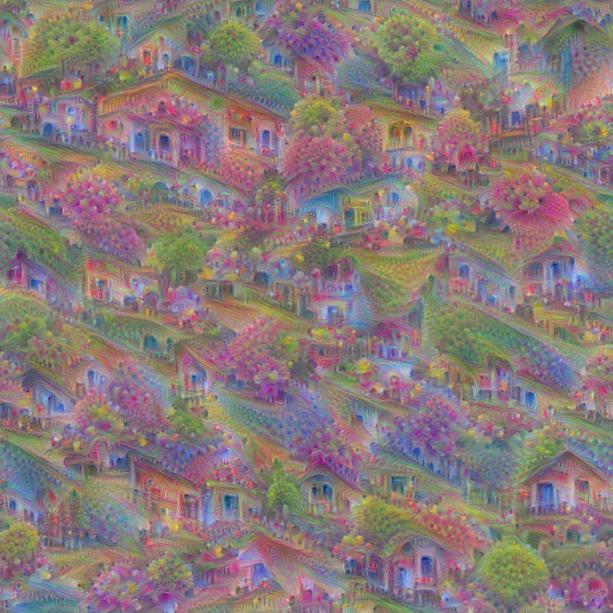

In [0]:
mixed4d = 'mixed4d_3x3_bottleneck_pre_relu'
mixed4d_65 = render_lapnorm(T(mixed4d)[:,:,:,65])

# Lower layers produce features of lower complexity.
mixed3b_101 = render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

# optimizing a linear combination of features often gives a "mixture" pattern.
combo__mixed4d_65__mixed3b_101 = render_lapnorm(T(mixed4d)[:,:,:,65]+T(mixed4d)[:,:,:,139], octave_n=4)

In [0]:
#### TF RUN CODE


render_lapnorm(T(layer)[:,:,:,65])

# Lower layers produce features of lower complexity.
render_lapnorm(T('mixed3b_1x1_pre_relu')[:,:,:,101])

# optimizing a linear combination of features often gives a "mixture" pattern.
render_lapnorm(T(layer)[:,:,:,65]+T(layer)[:,:,:,139], octave_n=4)



## Example: Face Interpolation

When we **interpolate** between points in the space, generating images at each point along the way, it's striking that (almost) every point in between looks like a person.

One can't but help thinking that these algorithms are beginning to learn some fundamental truths about what we as humans all have in common.

![celeb_1hr_man](https://media.giphy.com/media/1Bgck5vkuyNxSFPNmJ/giphy.gif)

Source: [youtube](https://www.youtube.com/watch?v=36lE9tV9vm0)

Paper: [*Progressive Growing of GANs for Improved Quality, Stability, and Variation*, Karras et al, 2018](http://research.nvidia.com/publication/2017-10_Progressive-Growing-of)

# Definition #3: **Exploring the *Concepts* within AI and what they means for us**

Among other things, this could encompass exploring AI's relationships to:
- our society
- the individual
- the nature of consciousness

## My explorations of concepts

## Example: SketchRNN

In [0]:
# TODO sketchrnn / DRAW / paint?

## Example: Treachery of Imagenet